# PAC+KNN

In [70]:
import numpy as np
from scipy.spatial.distance import cdist


cace = {}

def get_sig_matrix(A : np.array, num):
        # 将 train 转换为字节串（不可变类型）作为缓存键
    train_bytes = A.tobytes()

    # 如果缓存中已有结果，直接返回缓存的结果
    if train_bytes in cace:
        (eigenvalues, eigenvectors) = cace[train_bytes]
    else :
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        cace[train_bytes] = (eigenvalues, eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1] 
    sorted_eigenvalues = eigenvalues[sorted_indices] 
    sorted_eigenvectors = eigenvectors[:, sorted_indices]  

    top_eigenvectors = sorted_eigenvectors[:, :num]

    return top_eigenvectors

def find_nearest_columns(train, test):
    # 计算欧氏距离，返回一个 (test.shape[1], train.shape[1]) 的矩阵

    distances = cdist(test.T, train.T, metric='euclidean')
    # 对每一列（test的每一列）找到最近的 train 中的列索引
    nearest_indices = np.argmin(distances, axis=1)
    return nearest_indices

def count_mismatches(train_class, test_class, clasfi):
    # 直接比较test_class和train_class[clasfi]，返回布尔数组，求和得到不一致的次数
    return np.sum(test_class != train_class[clasfi])


In [79]:
cache = {}
def get_s_b(train: np.array):
    # 将 train 转换为字节串（不可变类型）作为缓存键
    train_bytes = train.tobytes()

    # 如果缓存中已有结果，直接返回缓存的结果
    if train_bytes in cache:
        return cache[train_bytes]
    
    # 如果没有缓存，进行计算
    train_centered = train - train.mean(axis=1, keepdims=True)
    C = np.full((train.shape[0], train.shape[0]), 0.0)
    for i in range(train.shape[1]):
        C += np.outer(train_centered[:, i:i+1], train_centered[:, i:i+1])

    # 将计算结果保存到缓存中
    cache[train_bytes] = C
    return C


def PCA(train : np.array, train_class : np.array, test : np.array, test_class : np.array,  dim):
    C = get_s_b(train)
    W = get_sig_matrix(C, dim)

    train, test = W.T @ train, W.T @ test
    clasfi = find_nearest_columns(train, test)
    error = count_mismatches(train_class, test_class, clasfi)
    return error / len(test_class)

def LDA(train : np.array, train_class : np.array, test : np.array, test_class : np.array,  dim):
    classes = np.unique(train_class)
    n_features = train.shape[0]
    S_W = np.zeros((n_features, n_features))
    for c in classes:
        class_samples = train[:, train_class == c]
        S_W += get_s_b(class_samples)
    
    S_B = get_s_b(train)

    W = get_sig_matrix(np.linalg.pinv(S_W) @ S_B, dim)

    train, test = W.T @ train, W.T @ test
    clasfi = find_nearest_columns(train, test)
    error = count_mismatches(train_class, test_class, clasfi)
    
    return error / len(test_class)

# test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# c = np.array([1, 1, 3])
# LDA(test, c, test, c , 1)

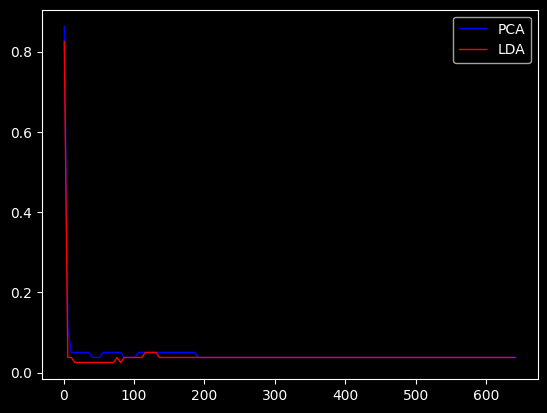

数据维度: (400, 644)
标签的最大类别值: 40


In [81]:
# 将每 5 个样本的前 4 个作为训练集，最后 1 个作为测试集
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 加载 .mat 文件
data = scipy.io.loadmat('ORLData_25.mat')

# 假设 'ORLData' 是 MATLAB 数据字典中的一个键
ORLData = data['ORLData']

# 转换为 numpy 数组
X = ORLData.T  # 转置
X = X.astype(float)  # 转换为 float 类型

# 获取样本的数量和维度
n, dim = X.shape
labels = X[:, -1]
labels = np.floor(labels).astype(int)

c = np.max(labels)

X = X[:, :-1]

indices = np.arange(X.shape[0])
# 将每 5 个样本的前 4 个作为训练集，最后 1 个作为测试集
train_indices = indices[indices % 5 != 4]
test_indices = indices[indices % 5 == 4]

# error = PCA(X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices], 100)
# error = LDA(X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices], 15)
x = range(1, X.shape[1]+1, 5)
A, B, C, D = X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices]
y = [PCA(A, B, C, D, a) for a in x]
plt.plot(x, y, label="PCA", color='b', linestyle='-', linewidth=1)

y = [LDA(A, B, C, D, a) for a in x]
plt.plot(x, y, label="LDA", color='r', linestyle='-', linewidth=1)
plt.legend()
plt.show()

# print(f"错误率: {error*100 : .3f}%")
print(f"数据维度: {X.shape}")
print(f"标签的最大类别值: {c}")


(846, 19)


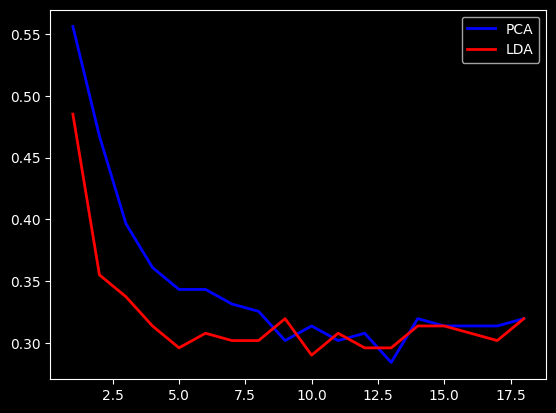

数据维度: (846, 18)
标签的最大类别值: 4


In [82]:
# 将每 5 个样本的前 4 个作为训练集，最后 1 个作为测试集
import numpy as np
import scipy.io

# 加载 .mat 文件
data = scipy.io.loadmat('vehicle.mat')

# 假设 'ORLData' 是 MATLAB 数据字典中的一个键
vehicle = data['UCI_entropy_data']['train_data'][0,0]


# 转换为 numpy 数组
X = vehicle.T  # 转置
X = X.astype(float)  # 转换为 float 类型

# 获取样本的数量和维度
n, dim = X.shape
print(X.shape)
labels = X[:, -1]
labels = np.floor(labels).astype(int)

c = np.max(labels)

X = X[:, :-1]

indices = np.arange(X.shape[0])
# 将每 5 个样本的前 4 个作为训练集，最后 1 个作为测试集
train_indices = indices[indices % 5 != 4]
test_indices = indices[indices % 5 == 4]

# error = PCA(X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices], 100)
# error = LDA(X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices], 15)

x = range(1, X.shape[1]+1)
A, B, C, D = X[train_indices].T, labels[train_indices], X[test_indices].T, labels[test_indices]
y = [PCA(A, B, C, D, a) for a in x]
plt.plot(x, y, label="PCA", color='b', linestyle='-', linewidth=2)

y = [LDA(A, B, C, D, a) for a in x]
plt.plot(x, y, label="LDA", color='r', linestyle='-', linewidth=2)
plt.legend()
plt.show()

# print(f"错误率: {error*100 : .3f}%")
print(f"数据维度: {X.shape}")
print(f"标签的最大类别值: {c}")
